# Evaluation of network communications

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip

## About the Datasets
There are 2 datasets:
- **data3**: contains the data of the communication in one day without any anomalous behavior;
- **test3**: contains the data of the communication in one day with anomalous behavior;

Each dataframe contains the following columns:
- `index`: the index of the row
- `timestamp`: the timestamp of the event
- `src_ip`: the source IP address
- `dst_ip`: the destination IP address
- `proto`: the protocol used
- `port`: the port used
- `up_bytes`: the number of bytes uploaded by the source
- `down_bytes`: the number of bytes downloaded by the source

In [9]:
non_anomalous_df = pd.read_parquet('datasets/dataset3/data3.parquet')
non_anomalous_df.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
779943,957860,192.168.103.11,142.250.200.99,tcp,443,22243,228517
779944,957930,192.168.103.11,193.126.240.146,tcp,443,34885,199897
779945,958055,192.168.103.11,193.126.240.146,tcp,443,25383,216980
779946,958066,192.168.103.11,193.126.240.146,tcp,443,19162,99479
779947,958171,192.168.103.11,193.126.240.146,tcp,443,7247,60469


In [5]:
anomalous_df = pd.read_parquet('datasets/dataset3/test3.parquet')
anomalous_df.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
174163,1488996,192.168.103.17,192.168.103.228,udp,53,210,611
174164,1489002,192.168.103.17,192.168.103.228,udp,53,204,580
174165,1489088,192.168.103.17,142.250.200.99,tcp,443,8967,57243
174166,1489284,192.168.103.17,142.250.200.99,tcp,443,4501,34854
174167,1489314,192.168.103.17,142.250.200.99,tcp,443,22478,178992


## Inside vs. Outside the Network

This part makes a comparison the number of packets sent inside and outside the network. As we can see, the number of packets sent outside the network is lower in the anomalous dataset than in the non-anomalous dataset. 

This could be an indicator of attacks like:
- **Internal Reconnaissance**: An attacker might be performing internal reconnaissance, leading to an increase in internal traffic and a corresponding decrease in external traffic.
- **Data Exfiltration preparation**: An attacker might be preparing for data exfiltration, leading to an increase in internal traffic and a corresponding decrease in external traffic.
- **Internal C&C Communication**: An attacker might be communicating with a C&C server inside the network, leading to an increase in internal traffic and a corresponding decrease in external traffic.

In [13]:
def inside_outside_network(dataframe, title_prefix=''):
    internal_network = ipaddress.IPv4Network('192.168.103.0/24')
    binternal = dataframe.apply(lambda x: ipaddress.ip_address(x['dst_ip']) in internal_network, axis=1)
    bexternal = dataframe.apply(lambda x: ipaddress.ip_address(x['dst_ip']) not in internal_network, axis=1)
    
    return binternal, bexternal

na_internal_network_packets, na_external_network_packets = inside_outside_network(non_anomalous_df, title_prefix='Non-anomalous')
print(f'Number of packets sent inside the network (Non-anomalous dataset): {na_internal_network_packets.sum()}')
print(f'Number of packets sent outside the network (Non-anomalous dataset): {na_external_network_packets.sum()}')
print(f'Ratio of packets sent outside the network (Non-anomalous dataset): {na_external_network_packets.sum() / len(non_anomalous_df) * 100:.2f}%')
print(f'Ratio of packets sent inside the network (Non-anomalous dataset): {na_internal_network_packets.sum() / len(non_anomalous_df) * 100:.2f}%')

print()

a_internal_network_packets, a_external_network_packets = inside_outside_network(anomalous_df, title_prefix='Anomalous')
print(f'Number of packets sent inside the network (Anomalous dataset): {a_internal_network_packets.sum()}')
print(f'Number of packets sent outside the network (Anomalous dataset): {a_external_network_packets.sum()}')
print(f'Ratio of packets sent outside the network (Anomalous dataset): {a_external_network_packets.sum() / len(anomalous_df) * 100:.2f}%')
print(f'Ratio of packets sent inside the network (Anomalous dataset): {a_internal_network_packets.sum() / len(anomalous_df) * 100:.2f}%')

Number of packets sent inside the network (Non-anomalous dataset): 280139
Number of packets sent outside the network (Non-anomalous dataset): 666458
Ratio of packets sent outside the network (Non-anomalous dataset): 70.41%
Ratio of packets sent inside the network (Non-anomalous dataset): 29.59%

Number of packets sent inside the network (Anomalous dataset): 359169
Number of packets sent outside the network (Anomalous dataset): 678661
Ratio of packets sent outside the network (Anomalous dataset): 65.39%
Ratio of packets sent inside the network (Anomalous dataset): 34.61%


## Inside the Network
In this section, we will analyze the traffic flow inside the network. We will look at who communicates with whom, the protocols used, and look for any anomalies in the communication.

#### Protocols used
##### Transport Layer Protocols
The packets are divided into two protocols: TCP and UDP. As we can see in the following plot, the number of TCP packets is higher than the number of UDP packets, with almost 90% of the packets being TCP packets.

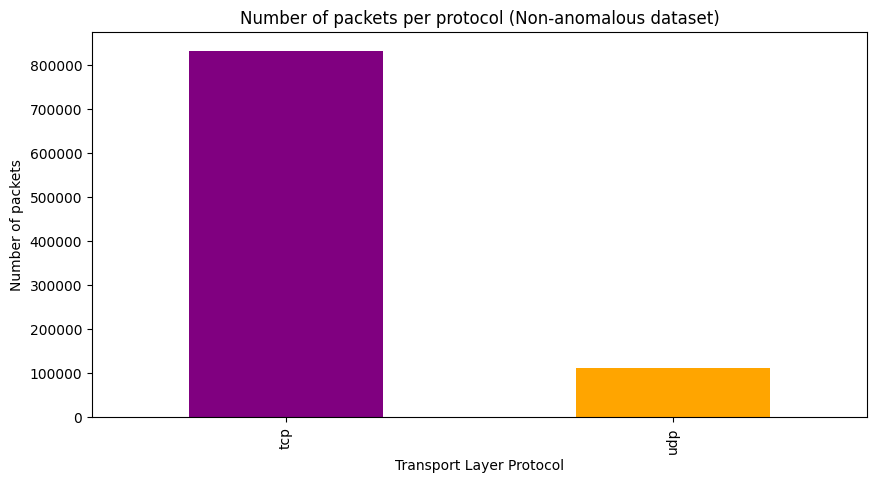

Ratio of TCP packets (Non-anomalous dataset): 88.06%
Ratio of UDP packets (Non-anomalous dataset): 11.94%


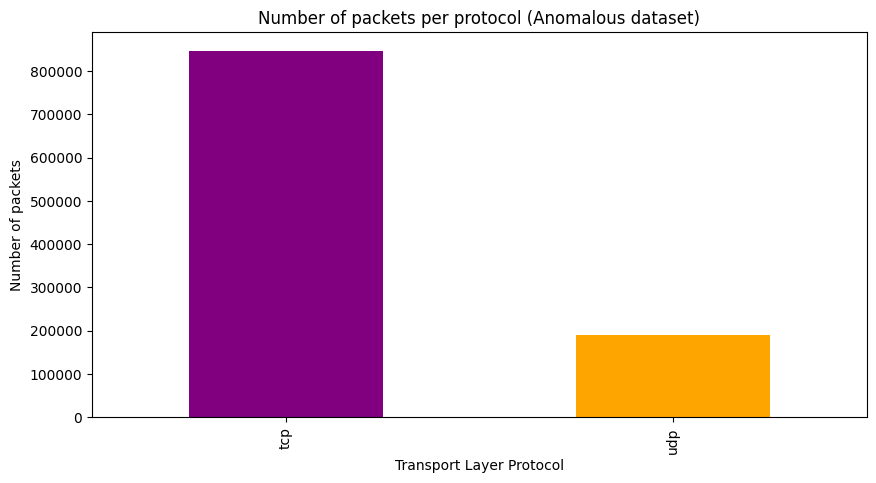

Ratio of TCP packets (Anomalous dataset): 81.69%
Ratio of UDP packets (Anomalous dataset): 18.31%


In [16]:
def transport_protocol_distribution(dataframe, title_prefix=''):
    plt.figure(figsize=(10, 5))
    # More neutral colors
    dataframe['proto'].value_counts().plot(kind='bar', color=['purple', 'orange'])
    plt.title(f'Number of packets per protocol ({title_prefix} dataset)')
    plt.xlabel('Transport Layer Protocol')
    plt.ylabel('Number of packets')
    plt.show()

    print(f'Ratio of TCP packets ({title_prefix} dataset): {len(dataframe[dataframe["proto"] == "tcp"]) / len(dataframe) * 100:.2f}%')
    print(f'Ratio of UDP packets ({title_prefix} dataset): {len(dataframe[dataframe["proto"] == "udp"]) / len(dataframe) * 100:.2f}%')


# Call the function for non-anomalous dataset
transport_protocol_distribution(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
transport_protocol_distribution(anomalous_df, title_prefix='Anomalous')

##### Application Layer Protocols

The following plot shows the number of packets per application layer protocol. All the packets are divided into 2 protocols: HTTPS and DNS. The number of DNS packets is lower than the number of HTTPS packets, with almost 90% of the packets being HTTPS packets. 

However, the anomalous datasets show a small difference between the number of DNS and HTTPS packets, with a higher number of DNS packets (7% more than the non-anomalous dataset). This could indicate attacks like DNS flooding.

In [ ]:
application_protocols = {
    '80': 'HTTP',
    '443': 'HTTPS',
    '22': 'SSH',
    '53': 'DNS',
    '21': 'FTP',
    '25': 'SMTP',
}

def protocol_distribution(dataframe, title_prefix=''):
    protocol_series = dataframe['port'].astype(str).map(application_protocols)

    if protocol_series.isnull().values.any():
        protocol_series = dataframe['port']

    plt.figure(figsize=(10, 5))
    protocol_series.value_counts().plot(kind='bar', color=['navy', 'green'])
    plt.title(f'Number of packets per application layer protocol ({title_prefix} dataset)')
    plt.xlabel('Application Layer Protocol')
    plt.ylabel('Number of packets')
    plt.show()

    print(f'Ratio of HTTPS packets ({title_prefix} dataset):',
          len(dataframe[dataframe['port'] == 443]) / len(dataframe))
    print(f'Ratio of DNS packets ({title_prefix} dataset):', len(dataframe[dataframe['port'] == 53]) / len(dataframe))


# Call the function for non-anomalous dataset
protocol_distribution(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
protocol_distribution(anomalous_df, title_prefix='Anomalous')

### Packets sent (per Source IP)

The number of packets sent by the top 100 source IPs varies between the non-anomalous and anomalous datasets. 

As we can see, two machines have sent a higher number of packets in the **anomalous dataset**:
- **192.168.103.125**
- **192.168.103.90**

Pointing out that the machines could be compromised or used for malicious purposes.


In [ ]:
def top_source_ips(dataframe, frequency='1ms', top_n=100, y_lim=60000, title_prefix=''):
    dataframe = dataframe.copy()
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])
    dataframe.set_index('timestamp', inplace=True)

    grouped = dataframe.groupby([pd.Grouper(freq=frequency), 'src_ip', 'dst_ip']).size().reset_index(name='packets')

    src_ip_counts = grouped.groupby('src_ip')['packets'].sum().sort_values(ascending=False)
    top_src_ip_counts = src_ip_counts.head(top_n)

    plt.figure(figsize=(20, 10))
    # Multi color bar plot
    top_src_ip_counts.plot(kind='bar', color=cm.rainbow(np.linspace(0, 1, top_n)))
    plt.title(f'{title_prefix} Number of packets sent by the top {top_n} source IPs')
    plt.xlabel('Source IP')
    plt.ylabel('Number of packets')
    plt.ylim(0, y_lim)
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.3)
    plt.tight_layout()
    plt.show()

    print(f'Top 10 source IPs ({title_prefix} dataset):\n')
    for ip, count in top_src_ip_counts.head(10).items():
        print(ip, "Packets sent:", count, "Percentage:", count / len(dataframe) * 100)


# Call the function for non-anomalous dataset
top_source_ips(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
top_source_ips(anomalous_df, title_prefix='Anomalous')

#### Downloads/Uploads

The following plot shows the number of bytes uploaded and downloaded for both anomalous and non-anomalous datasets. This could be an indicator of a possible attack, as the number of bytes uploaded is higher than the number of bytes downloaded in the anomalous dataset.

We found 2 machines that have **uploaded** a higher number of bytes in the anomalous dataset:
- **192.168.103.69**
- **192.168.103.85**

In [ ]:
def download_upload(dataframe, title_prefix='', top_n=50):
    dataframe = dataframe.copy()
    # Calculate total bytes (uploads + downloads) for each source IP
    dataframe['total_bytes'] = dataframe['up_bytes'] + dataframe['down_bytes']

    # Get the top N source IPs with the highest total bytes
    top_src_ips = dataframe.groupby('src_ip')['total_bytes'].sum().nlargest(top_n).index

    # Filter the dataframe to include only the top N source IPs
    top_data = dataframe[dataframe['src_ip'].isin(top_src_ips)]

    print(top_data[:10].to_string())

    # Plot the data
    plt.figure(figsize=(15, 7))  # Adjusting figure size for better readability
    top_data.groupby('src_ip')['up_bytes'].sum().plot(kind='bar', width=0.4, color='blue', position=1, label='Uploads')
    top_data.groupby('src_ip')['down_bytes'].sum().plot(kind='bar', width=0.4, color='red', position=0,
                                                        label='Downloads')

    plt.title(f'Number of bytes uploaded and downloaded per source IP ({title_prefix} dataset)')
    plt.xlabel('Source IP')
    plt.ylabel('Number of MBs')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print(f'Number of bytes uploaded ({title_prefix} dataset):', dataframe['up_bytes'].sum())
    print(f'Number of bytes downloaded ({title_prefix} dataset):', dataframe['down_bytes'].sum())


# Call the function for non-anomalous dataset
download_upload(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
download_upload(anomalous_df, title_prefix='Anomalous')

### Download/Upload on DNS packets

However, the number of bytes uploaded and downloaded for DNS packets showcase that the previous detected machines (in the number of packets sent) have the highest number of bytes uploaded and downloaded for DNS packets.

In [ ]:
def download_upload_dns(dataframe, title_prefix='', top_n=50):
    dns_port = 53
    # Filter the dataframe to include only DNS packets
    dns_data = dataframe[dataframe['port'] == dns_port].copy()

    # Calculate total bytes (uploads + downloads) for each source IP
    dns_data['total_bytes'] = dns_data['up_bytes'] + dns_data['down_bytes']

    # Get the top N source IPs with the highest total bytes
    top_src_ips = dns_data.groupby('src_ip')['total_bytes'].sum().nlargest(top_n).index

    # Filter the dataframe to include only the top N source IPs
    top_data = dns_data[dns_data['src_ip'].isin(top_src_ips)]

    # Plot the data
    plt.figure(figsize=(15, 7))  # Adjusting figure size for better readability
    top_data.groupby('src_ip')['up_bytes'].sum().plot(kind='bar', width=0.4, color='blue', position=1, label='Uploads')
    top_data.groupby('src_ip')['down_bytes'].sum().plot(kind='bar', width=0.4, color='red', position=0,
                                                        label='Downloads')

    plt.title(f'Number of bytes uploaded and downloaded per source IP for DNS packets ({title_prefix} dataset)')
    plt.xlabel('Source IP')
    plt.ylabel('Number of MBs for DNS packets')
    plt.legend()
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    print(f'Number of bytes uploaded for DNS packets ({title_prefix} dataset):', dns_data['up_bytes'].sum())
    print(f'Number of bytes downloaded for DNS packets ({title_prefix} dataset):', dns_data['down_bytes'].sum())

    # Get the src_ip with the highest number of bytes uploaded. Then print the ratio of its uploaded and downloaded bytes
    highest_uploaded_ip = dns_data.groupby('src_ip')['up_bytes'].sum().idxmax()
    uploaded_bytes = dns_data[dns_data['src_ip'] == highest_uploaded_ip]['up_bytes'].sum()
    downloaded_bytes = dns_data[dns_data['src_ip'] == highest_uploaded_ip]['down_bytes'].sum()

    print(f'IP with the highest uploaded bytes ({title_prefix} dataset):', highest_uploaded_ip)
    print(f'Uploaded bytes for the source IP with the highest uploaded bytes ({title_prefix} dataset):', uploaded_bytes)
    print(f'Downloaded bytes for the source IP with the highest uploaded bytes ({title_prefix} dataset):',
          downloaded_bytes)
    print(
        f'Ratio of uploaded and downloaded bytes for the source IP with the highest uploaded bytes ({title_prefix} dataset):',
        uploaded_bytes / downloaded_bytes)


# Call the function for non-anomalous dataset
download_upload_dns(non_anomalous_df, title_prefix='Non-anomalous')

# Call the function for anomalous dataset
download_upload_dns(anomalous_df, title_prefix='Anomalous')

### Geolocation of all the traffic sent

From the traffic sent, we can see that the majority of the traffic is sent to the United States. This is the same for both the anomalous and non-anomalous datasets. This could be an indicator that the traffic is sent to a cloud provider, as many cloud providers are located in the United States.

In [ ]:
gi = pygeoip.GeoIP('./datasets/GeoIP_DBs/GeoIP.dat')

# Is destination IPv4 a public address?
NET = ipaddress.IPv4Network('192.168.103.0/24')
bpublic = non_anomalous_df.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET, axis=1)
bpublic2 = anomalous_df.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET, axis=1)

# Geolocalization of public destination adddress
country_code = non_anomalous_df[bpublic]['dst_ip'].apply(lambda y: gi.country_code_by_addr(y)).to_frame(
    name='country_code')
country_code2 = anomalous_df[bpublic2]['dst_ip'].apply(lambda y: gi.country_code_by_addr(y)).to_frame(
    name='country_code')

# Add country code count
country_code = country_code['country_code'].value_counts().sort_values(ascending=False)
country_code2 = country_code2['country_code'].value_counts().sort_values(ascending=False)

country_code = country_code / non_anomalous_df.shape[0] * 100
country_code2 = country_code2 / anomalous_df.shape[0] * 100

# Show the country code count
print('Non-anomalous dataset:')
print(country_code)
print('Anomalous dataset:')
print(country_code2)

Given a threshold of 1% in variation, we can see the following countries that have a significant variation in the number of packets sent.

Being the following countries new in the anomalous dataset:
- **RU**: Russia
- **UA**: Ukraine

In [ ]:
# Create a list to store the comparison results
comp_list = []

# Iterate through the country codes in the non-anomalous dataset
for country in country_code.index:
    if country in country_code2:
        # Calculate the difference for existing countries in both datasets
        dif = country_code2[country] - country_code[country]
        comp_list.append({'country': country, 'variation': dif, 'is_new': False})
    else:
        # Handle the case where the country code is not in the anomalous dataset
        comp_list.append({'country': country, 'variation': -country_code[country], 'is_new': False})

# Handle the new country codes that are only in the anomalous dataset
for country in country_code2.index:
    if country not in country_code:
        comp_list.append({'country': country, 'variation': country_code2[country], 'is_new': True})

# Convert the list to a DataFrame
comp = pd.DataFrame(comp_list)

# Print the comp DataFrame given a threshold of 1% in variation
threshold = 0.01
print(comp[comp['variation'] > threshold])

Although the anomalous dataset has **38** new country codes that do not appear in the non-anomalous dataset. This could indicate that the traffic is sent to a different location, which could be an indicator of an attack.

In [ ]:
new_country_codes = set(country_code2.index) - set(country_code.index)
new_country_codes_list = list(new_country_codes)
new_country_codes_df = country_code2.loc[new_country_codes_list].sort_values(ascending=False)

print(f'The anomalous dataset has {len(new_country_codes_df)} new country codes that do not appear in the non-anomalous dataset.')
print(new_country_codes_df)

Now we are going to analyze to see which internal machines are sending traffic to these new countries.

In [ ]:
sus_ips = []
sus_geo = ['RU', 'UA']

for geo in sus_geo:
    sus_ips.extend(anomalous_df[anomalous_df['dst_ip'].apply(lambda x: gi.country_code_by_addr(x) == geo)]['src_ip'].unique())
    
# Remove the duplicates ips 
sus_ips = list(set(sus_ips))
    
print(f'The following internal machines are sending traffic to the new countries: {sus_ips}')

### Traffic Sent by the possible compromised machines

For that reason, we will analyze the traffic sent by the potential infected machines.

To do so, we will need to have the geographical location of the destination IP addresses. We will use the GeoIP database to get the location of the destination IP addresses.

In [ ]:
sus_ips = ['192.168.103.185', '192.168.103.84', '192.168.103.169']
anomalous_df = pd.read_parquet('datasets/dataset3/test3.parquet')

def get_domain_name(ip):
    try:
        return dns.resolver.resolve(dns.reversename.from_address(ip), 'PTR')[0].to_text()
    except:
        return None

def traffic_sent_by_ip_domain(dataframe, ip, frequency='1min'):
    dataframe['timestamp'] = pd.to_datetime(dataframe['timestamp'])
    
    internal_network = ipaddress.IPv4Network('192.168.103.0/24')
    dataframe = dataframe[~dataframe['dst_ip'].apply(lambda x: ipaddress.ip_address(x) in internal_network)]
    
    dataframe = dataframe.copy()  # Create a copy to avoid SettingWithCopyWarning
    
    dataframe.loc[:, 'timestamp_minute'] = dataframe['timestamp'].dt.floor('min')  # Using .loc to set values
    
    # DNS resolution
    dataframe['domain'] = dataframe['dst_ip'].map(get_domain_name)
    
    dataframe = dataframe.dropna(subset=['domain'])
    
    # Calculate the sum of upload and download bytes for each DNS name
    dataframe_grouped = dataframe.groupby('domain').agg({'up_bytes': 'sum', 'down_bytes': 'sum'}).reset_index()
    
    # Plot the data
    plt.figure(figsize=(20, 10))
    plt.plot(dataframe_grouped['timestamp_minute'], dataframe_grouped['up_bytes'], label='Uploads')
    plt.plot(dataframe_grouped['timestamp_minute'], dataframe_grouped['down_bytes'], label='Downloads')
    plt.title(f'Number of bytes uploaded and downloaded by {ip} per minute')
    plt.xlabel('Time')
    plt.ylabel('Number of bytes')
    plt.legend()
    plt.show()    

for ip in sus_ips:
    print(f'Traffic sent by {ip}:')
    traffic_sent_by_ip_domain(anomalous_df, ip)

### Domains of the traffic sent by the potential compromised machines